In [356]:
# Define path where to find the module. This allows for a different path depending on where the code is running (my mac or the cluster)
import os
import sys

# Define candidate paths
module_path_list = [
    '/Users/steven/academic-iCloud/Python/modules',
    '/hpc/aklicka/Python/modules'
]

data_path_list = [
    '/Users/steven/Python-data',
    '/hpc/aklicka/Python-data/training-set-1'
]

# Resolve actual paths
module_path = next((p for p in module_path_list if os.path.exists(p)), None)
data_path = next((p for p in data_path_list if os.path.exists(p)), None)

# Check and report missing paths
if module_path is None:
    print("Error: Could not locate a valid module path.")
if data_path is None:
    print("Error: Could not locate a valid data path.")

if module_path is None or data_path is None:
    sys.exit(1)

# Print resolved paths
print(f"module_path = {module_path}")
print(f"data_path = {data_path}")

# Reduce TensorFlow verbosity
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'


module_path = /hpc/aklicka/Python/modules
data_path = /hpc/aklicka/Python-data/training-set-1


In [357]:
# # Ensure modules are reloaded 
%load_ext autoreload
%autoreload 2

# Import standard modules
import numpy as np

import platform

from datetime import datetime

# Add custom module path to list
sys.path.append(module_path)

# Import custom module
import SRSML24.data_prep as dp
import SRSML24.model as m
import SRSML24.utils as ut

import tensorflow as tf
#from tensorflow.keras.optimizers.legacy import Adam 
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt

import pandas as pd
from IPython.display import display, Markdown

import skimage as ski
import skimage.morphology as morphology
import skimage
from skimage import morphology, measure

#import platform 

m.print_system_info()

start_time = dp.current_datetime()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload

Python version: 3.9.21 (main, Dec 11 2024, 16:24:11) 
[GCC 11.2.0]
TensorFlow version: 2.4.1
TensorFlow is built with CUDA: True
TensorFlow is built with ROCm: False

System: Linux 4.18.0-553.22.1.el8_10.x86_64 (x86_64)
Platform: Linux-4.18.0-553.22.1.el8_10.x86_64-x86_64-with-glibc2.28
Processor: x86_64

Number of GPUs available to TensorFlow: 1
GPU Device: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')

>>> Running with GPU available <<<  (Linux-4.18.0-553.22.1.el8_10.x86_64-x86_64-with-glibc2.28)

Current time 2025-06-18 12:08:17


In [385]:
# Parameters for windows creation
# General
job_name = 'June_25_BIG_model'
verbose = False             # Set this True to print out more information

# MTRX preprocessing
flatten_method = 'poly_xy'
pixel_density = 15.0        # Convert all images to a constant pixel density
pixel_ratio = 0.7           # If an image has less than this % in the slow scan direction it is discarded
data_scaling = 1.e9         # Scale the z-height of the data

# Windowing
window_size = 32            # Window size for training/validation
window_pitch = 8            # Window pitch for training/validation

# Data saving options
save_windows = True         # Save the windows as numpy files
together = True             # Set this True to save image windows for a mtrx image as a single file rather than separate files.
save_jpg = False            # Save the full image as a jpg
collate = False             # Set this True to remove all subfolder directories and save all data in root data path
save_window_jpgs = False    # Save the windows as jpgs for inspection

# Parameters for training
model_name = 'unet_' + job_name
batch_size = 128
buffer_size = 12800 # shuffling
learning_rate = 1e-4
epochs = 5

# Parameters for clustering
cluster_model_name = model_name + '_kmeans'
cluster_batch_size = 5120 # This is the number of latent features in a batch for clustering. 
                          # Does not have to be the same as for training and probably should 
                          # be larger. 
cluster_buffer_size = cluster_batch_size * 5    # shuffling buffer
num_clusters=20                                 # Desired number of clusters (centroids) to form in the data.
max_iter=1000                                   # Maximum iterations allowed for each mini-batch to refine centroids.
reassignment_ratio=0.05                         # Fraction of clusters reassigned per step; lower values stabilize updates.

# Parameters for PREDICTIONS
predict_window_pitch = 2                        # Window pitch for prediction
predictions_batch_size = 2**15                  # Batch size for predictions


# DATA LIMITS FOR TESTING THE CODE
mtrx_train_data_limit = None                    # Number of MTRX files to process (training)
mtrx_test_data_limit = None                     # Number of MTRX files to process (validation)

train_data_limit = 200                         # Limit the data used in the autoencoder training
test_data_limit = 50                          # Limit the data used in the autoencoder training (validation)

# Step 2
cluster_model_spectral_name = model_name + "_spectral"

In [359]:

job_data_path = dp.create_new_data_path(data_path, job_name, include_date=False)

mtrx_train_path = os.path.join(data_path, 'mtrx/train')
mtrx_test_path = os.path.join(data_path, 'mtrx/test')
mtrx_predict_path = os.path.join(data_path, 'mtrx/predict')

model_path = os.path.join(job_data_path,'model')
cluster_model_path = os.path.join(job_data_path,'cluster_model')

latent_features_path = os.path.join(job_data_path, 'latent_features')
predict_latent_features_path = os.path.join(job_data_path, 'latent_features_predictions')

windows_train_path = os.path.join(job_data_path, 'windows/train')
windows_test_path = os.path.join(job_data_path, 'windows/test')
windows_predict_path = os.path.join(job_data_path, 'windows/predict')

predictions_path = os.path.join(job_data_path, f'predictions')

train_feature_windows_path = os.path.join(job_data_path, 'feature_windows/train')
predict_feature_windows_path = os.path.join(job_data_path, 'feature_windows/predict')
train_feature_windows_latent_path = os.path.join(job_data_path, 'feature_windows_latent/train')
predict_feature_windows_latent_path = os.path.join(job_data_path, 'feature_windows_latent/predict')
feature_predictions_path = os.path.join(job_data_path, 'feature_predictions')

cluster_model_feature_windows_path = os.path.join(job_data_path, 'cluster_model_feature_windows')

### Process Matrix format data to windows for making predictions 


In [ ]:
dp.delete_data_folders(
    job_data_path, 
    subdirectories=['windows/predict','windows-jpg/predict','jpg/predict'],
    override=True)

In [ ]:
# Prediction data in MTRX format
mtrx_predict_file_list, _ = dp.list_files_by_extension(mtrx_predict_path,'Z_mtrx',verbose=False)

dp.process_mtrx_files(
    mtrx_predict_file_list,
    job_data_path, # save data path
    flatten_method = flatten_method, pixel_density = pixel_density, pixel_ratio = pixel_ratio,
    data_scaling = data_scaling, window_size = window_size, 
    window_pitch = predict_window_pitch,
    save_windows = save_windows,
    save_window_jpgs=save_window_jpgs,
    save_jpg = save_jpg,
    together = together,
    collate = collate,
    verbose = verbose
)

### Step 1: Making cluster image. Make predictions using the trained autoencoder and KMEANS models. Extract feature windows

In step 1, all windows are used. Latent vectors relate to windows extracted from the entire image.

In [360]:
# Load the trained autoencoder
step1_autoencoder_model = m.load_model(model_path, model_name=model_name)

# Load a previously saved cluster model from disk
step1_cluster_model = m.load_cluster_model(cluster_model_path, model_name=cluster_model_name)

Model loaded from: /hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/model/unet_June_25_BIG_model.keras
Cluster model loaded from: /hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/cluster_model/unet_June_25_BIG_model_kmeans.pkl


In [361]:
max_size_blob = 3000 #maximum pixel area of a blob to keep in the image
area_threshold = 50 #minimum pixel area of a blob to keep in the image
feature_size = 16 #radius of feature window taken from the centroid of the blob, actual window size is 2*feature_size

In [362]:
step1_predict_files, step1_num_predict = dp.list_files_by_extension(windows_predict_path, 'npy')

# Get the corresponding image coordimages list file
step1_prediction_windows_coordinates_file_list , _ = dp.list_files_by_extension(windows_predict_path,'.txt',verbose=False)
step1_prediction_windows_coordinates_file_list = [
    name for name in step1_prediction_windows_coordinates_file_list 
    if "coordinates" in name
]


Found 32 files with extension 'npy' in directory:
/hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/windows/predict
Found 64 files with extension '.txt' in directory:
/hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/windows/predict


### Only run next code window if you do not have the feature windows already saved

In [ ]:
dp.delete_data_folders(job_data_path, subdirectories=["feature_windows/predict"], override=True)

for image_num in range(len(step1_predict_files)):
    prediction_file = step1_predict_files[image_num]  
    coords_file = step1_prediction_windows_coordinates_file_list[image_num]  

    #get reconstructed image and cluster image
    reconstructed_img, cluster_img = m.reconstruct_predict(prediction_file, coords_file, step1_autoencoder_model, step1_cluster_model, window_size, predictions_batch_size)

    # Detect features and find centers
    #labeled_array, centers, num_features = m.detect_features_better(cluster_img, max_size=max_size_blob, area_threshold=area_threshold)
    features, centers, labeled_array, num_features = m.detect_features_find_centres(cluster_img, max_size=70000, area_threshold=64,)


    #extract feature windows from the reconstructed image
    feature_windows = m.extract_feature_windows(reconstructed_img, centers, px=feature_size)

    image_name = os.path.splitext(os.path.basename(prediction_file))[0]
    # Save the feature windows to disk for each reconstructed image
    dp.save_feature_windows_together(feature_windows, centers, predict_feature_windows_path, base_filename=image_name, verbose=True)

    #save / display the reconstructed and cluster images with centers highlighted
    m.display_reconstructed_and_cluster_images_and_extracted_features(reconstructed_img, cluster_img, labeled_array, centers,
                                                                      save_to_disk=True, output_path=feature_predictions_path, image_name=image_name, dpi=150)

### Step 2: Cluster Feature windows. Display labeled features.

Step 2 only uses windows cut around the found features in the image. The latent vectors for step 2 are related to the 'feature' windows.

Found 32 files with extension 'npy' in directory:
/hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/feature_windows/predict
Not shuffling
Data pipeline created with 1 files, batch size: 32768, window size: 32
Sample batch shape: (76, 32, 32, 1)

Deleted: /hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/feature_windows_latent/predict
All specified folders have been successfully deleted.
Processing batch 1, input shape: [76 32 32  1]
Latent features shape for batch 1: (76, 4096)
Saved latent features for batch 1 to /hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/feature_windows_latent/predict/feature_windows_latent_features_predict_batch_0.npy

All latent features have been saved to /hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/feature_windows_latent/predict.
Sample batch shape: (76, 4096)
Found 1 files with extension 'npy' in directory:
/hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/feature_windows_latent/predict
Data pipeline created wi

/hpc/aklicka/.conda/envs/tf-adam/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


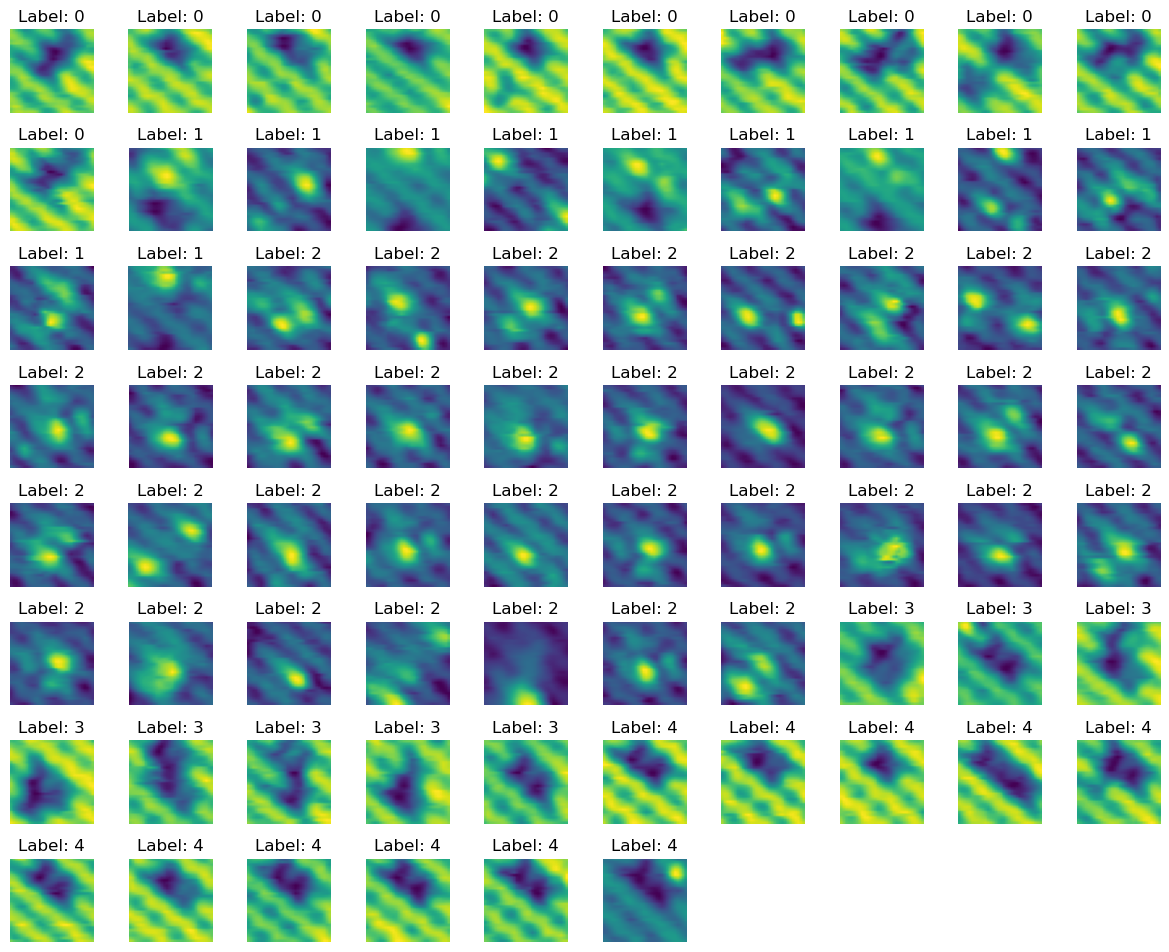

In [441]:
# Prediction data - tensorflow data pipeline of feature window images
step2_predict_files, step2_num_predict = dp.list_files_by_extension(predict_feature_windows_path, 'npy')

#for image_num in range(len(predict_files)):
image_num = 2

#create a dataset for each image
step2_predict_dataset = m.create_tf_dataset_batched(
    step2_predict_files[image_num:image_num+1],  # Use only one file for predictions
    batch_size=predictions_batch_size, 
    #buffer_size=cluster_buffer_size, 
    window_size=feature_size*2,  # feature windows are 2*feature_size
    is_autoencoder=True, 
    shuffle=False)

dp.delete_data_folders(job_data_path, subdirectories=["feature_windows_latent/predict"], override=True)

#create latent features for each image
m.extract_latent_features_to_disk_from_prebatched_windows(
    step1_autoencoder_model, 
    step2_predict_dataset, 
    predict_feature_windows_latent_path, 
    bottleneck_layer_name='bottleneck',
    features_name='feature_windows_latent_features_predict',
    return_array=False,
    verbose=True)

step2_predict_latent_features_files, step2_num_latent_files = dp.list_files_by_extension(predict_feature_windows_latent_path, 'npy')

# Load the latent features from disk into a tensor dataset pipeline
step2_predict_latent_features_dataset = m.create_latent_features_tf_dataset(
    step2_predict_latent_features_files,
    batch_size=cluster_batch_size,
    shuffle=False, 
    shuffle_buffer_size=cluster_buffer_size)

# Load a previously saved cluster model from disk
step2_cluster_model = m.load_cluster_model(cluster_model_feature_windows_path, model_name=cluster_model_name)
step2_cluster_model_spectral = m.load_cluster_model(cluster_model_feature_windows_path, model_name=cluster_model_spectral_name)


# load latent features as a numpy array with shape (num features, latent vector lenght)
data = np.load(step2_predict_latent_features_files[0])

# use cluster model to predict labels for each feature window. shape (num features,)
#labels = step2_cluster_model.predict(data)
labels = step2_cluster_model_spectral.fit_predict(data)

# loads the image windows. Shape (num features, 32, 32)
image = np.load(step2_predict_files[image_num])

# Sort the labels numerically, while also sorting the corresponding feature windows
sorted_indices = np.argsort(labels)
sorted_labels = labels[sorted_indices]
sorted_feature_windows = image[sorted_indices]
# Display the first 64 images in a 8x8 grid along with their labels
def display_images_with_labels(images, labels, num_images=64):
    plt.figure(figsize=(12, 12))
    for i in range(num_images):
        plt.subplot(10, 10, i + 1)
        plt.imshow(images[i].squeeze(), cmap='viridis')
        plt.title(f'Label: {labels[i]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()
display_images_with_labels(sorted_feature_windows, sorted_labels, num_images=image.shape[0])


#### Display reconstructed image with features circled

In [442]:
#get reconstructed image and cluster image
reconstructed_img, cluster_img = m.reconstruct_predict(step1_predict_files[image_num], step1_prediction_windows_coordinates_file_list[image_num], step1_autoencoder_model, step1_cluster_model, window_size, predictions_batch_size)

# Get the corresponding image coordimages list file
step2_prediction_windows_coordinates_file_list , _ = dp.list_files_by_extension(predict_feature_windows_path,'.txt',verbose=False)

# Get the coordinates for a specific image with index `image_num`
coordinates_data = np.loadtxt(step2_prediction_windows_coordinates_file_list[image_num], skiprows=1, dtype=float).astype(np.int64)


---
Processing file default_2011Feb11-105510_STM-STM_Spectroscopy--110_16_FD_all_windows.npy
Not shuffling
Data pipeline created with 1 files, batch size: 32768, window size: 32
Sample batch shape: (32768, 32, 32, 1)
......Combined latent features shape: (189225, 4096)
Found 32 files with extension '.txt' in directory:
/hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/feature_windows/predict


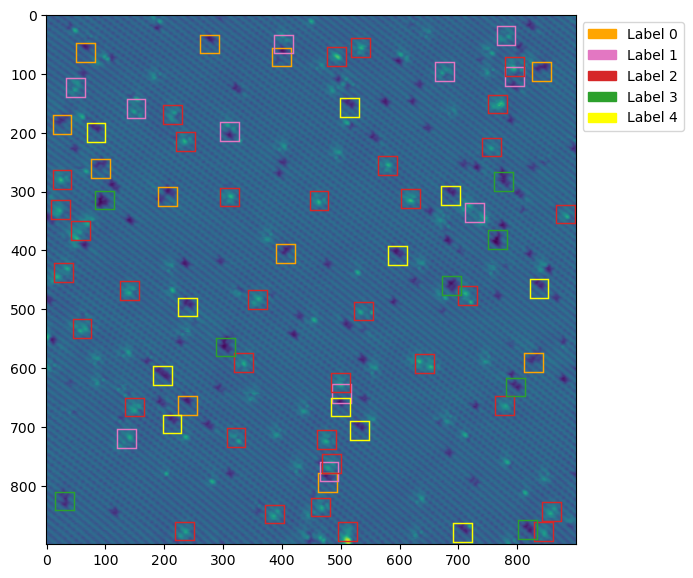

In [443]:
#import the tab10 colormap as an array
import matplotlib.patches as mpatches

colormap = [ "orange", "tab:pink", "tab:red", "tab:green", "yellow", "purple",  "tab:gray",]
unique_labels = np.unique(labels)

patches = []
label_names = []

fig, ax = plt.subplots(figsize = (7,7))
ax.imshow(reconstructed_img)

for number in unique_labels:
    indexes = [i for i, val in enumerate(labels) if val == number]
    for index in indexes:
        y, x = coordinates_data[index]
        r = plt.Rectangle((x-16, y-16),width = 32, height = 32, color = colormap[number], linewidth=1.05, fill = False)
        ax.add_patch(r)
    
    # Add a patch for the legend (only once per label)
    patch = mpatches.Patch(color=colormap[number], label=f"Label {number}")
    patches.append(patch)
    label_names.append(f"Label {number}")

ax.legend(handles=patches, labels=label_names, loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()

plt.show()


Found 32 files with extension 'jpg' in directory:
/hpc/aklicka/Python-data/training-set-1/June_25_BIG_model/feature_predictions


(-0.5, 2699.5, 899.5, -0.5)

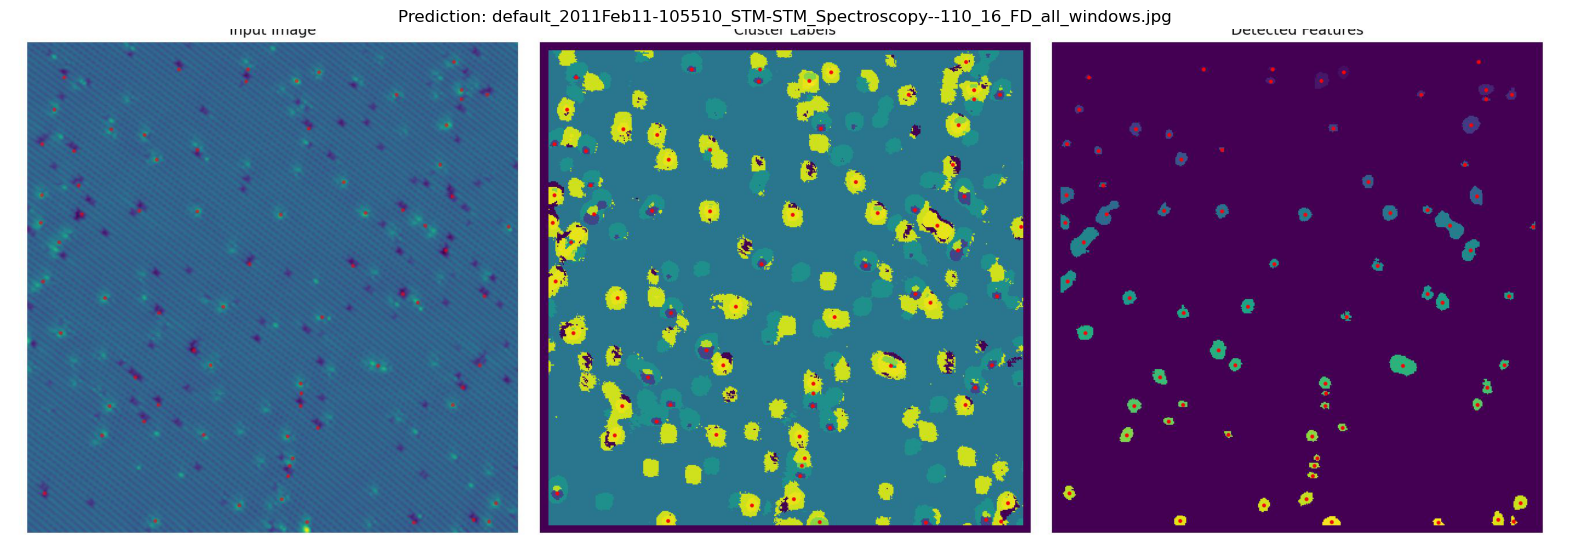

In [444]:
jpg_predictions_files, num_jpg_predict = dp.list_files_by_extension(feature_predictions_path, 'jpg')
#display a jpg prediction with index jpg_predictions_files[0]
jpg_prediction_file = jpg_predictions_files[image_num]
jpg_prediction = ski.io.imread(jpg_prediction_file)
plt.figure(figsize=(20, 10))
plt.imshow(jpg_prediction, cmap='viridis')
plt.title(f'Prediction: {os.path.basename(jpg_prediction_file)}')
plt.axis('off')

In [445]:
cluster_img.shape

(900, 900)

In [446]:
from skimage.color import rgb2gray
from skimage.feature import blob_dog, blob_log, blob_doh
from math import sqrt

image_gray = cluster_img.astype(float)
blobs_log = blob_log(image_gray, max_sigma=30, num_sigma=10, threshold=0.1)
print("Number of blobs detected using LoG:", len(blobs_log))
# Compute radii in the 3rd column.
blobs_log[:, 2] = blobs_log[:, 2] * sqrt(2)

blobs_dog = blob_dog(image_gray, max_sigma=30, threshold=0.1)
blobs_dog[:, 2] = blobs_dog[:, 2] * sqrt(2)
print("Number of blobs detected using DoG:", len(blobs_dog))

blobs_doh = blob_doh(image_gray, max_sigma=30, threshold=0.01)
print
blobs_list = [blobs_log, blobs_dog, blobs_doh]
colors = ['yellow', 'lime', 'red']
titles = ['Laplacian of Gaussian', 'Difference of Gaussian', 'Determinant of Hessian']
sequence = zip(blobs_list, colors, titles)

fig, axes = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

for idx, (blobs, color, title) in enumerate(sequence):
    ax[idx].set_title(title)
    ax[idx].imshow(cluster_img, interpolation='nearest')
    for blob in blobs:
        y, x, r = blob
        c = plt.Circle((x, y), r, color=color, linewidth=2, fill=False)
        ax[idx].add_patch(c)
    ax[idx].set_axis_off()

plt.tight_layout()
plt.show()

Number of blobs detected using LoG: 2593
Number of blobs detected using DoG: 3597


KeyboardInterrupt: 

In [ ]:
image_gray = cluster_img.astype(float)
image_gray = np.expand_dims(image_gray, axis=-1)  # Now shape is (900, 900, 1)


In [454]:
blobs_dog = blob_log(image_gray, max_sigma=30, threshold=0.1)
blobs_dog[:, 2] = blobs_dog[:, 2] * sqrt(2)
print("Number of blobs detected using DoG:", len(blobs_dog))

Number of blobs detected using DoG: 1630


In [460]:
print(blobs_dog)

[[282.          27.           0.          10.66666667]
 [874.         231.           0.          10.66666667]
 [578.          89.           0.           1.        ]
 ...
 [441.         637.           0.           1.        ]
 [278.         181.           0.           4.22222222]
 [728.         407.           0.           4.22222222]]


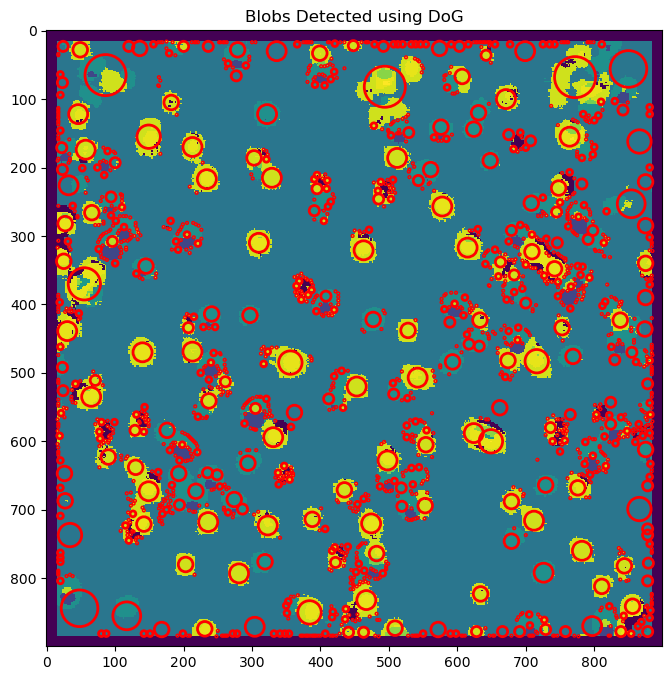

In [464]:
fig, ax = plt.subplots(figsize=(10, 8))  # Adjust figsize (width, height) as desired
color = 'red'  # Color for the circles
ax.set_title('Blobs Detected using DoG')
ax.imshow(cluster_img, interpolation='nearest')
for blob in blobs_dog:
    y, x, z, r = blob
    c = plt.Circle((x, y), r, color=color, linewidth=2, fill=False)
    ax.add_patch(c)